In [7]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git "pillow<7" ttach

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-bvwmzwox
  Running command git clone --filter=blob:none -q https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-bvwmzwox
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 61e9babae8600351b02b6e90864e4807f44f2d4a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 881.9 MB 5.4 kB/s             
     |████████████████████████████████| 23.3 MB 47.9 MB/s            
     |████████████████████████████████| 881.9 MB 5.6 kB/s             
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25901 sha256=163ec40fa45965a221419031321d018a0fe3f0d916cc7829e97b8a5b4c5cfb75
  Stored in directory: /tmp/pip-ephem-wheel-cache-5k4llts2/wheels/b8/cc/ea/8cd1ef511f18b52e1cf2c2c77d57e588cb389c137282ba9e0d
Successfully built grad-cam
  Attempting unin

In [8]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
import random
import json
import datetime
import time

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 

tqdm.pandas()

In [9]:
skills = pd.read_csv("../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
skills = dict(zip(skills.index, skills.values))

In [11]:
certs = pd.read_csv("../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
certs = dict(zip(certs.index, certs.values))

In [13]:
licenses = pd.read_csv("../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [14]:
licenses = dict(zip(licenses.index, licenses.values))

In [15]:
languages = pd.read_csv("../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
languages = dict(zip(languages.index, languages.values))

In [17]:
addresses = pd.read_csv("../Data/addresses_one-hot.csv").set_index("candidate_id")
addresses.head()

,0
candidate_id,
84556,90
84612,48
84731,3766
85437,3812
85627,1556


In [18]:
addresses = dict(zip(addresses.index, addresses.values))

In [19]:
w2v = json.load(open("../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [157]:
df_pred = pd.read_csv("../Data/df_pred_ext.csv").drop("Unnamed: 0", axis=1)

In [158]:
df_pred["time_between"] = (df_pred["time_between"] - df_pred["time_between"].mean()) / df_pred["time_between"].std()
df_pred["time_spent"] = (df_pred["time_spent"] - df_pred["time_spent"].mean()) / df_pred["time_spent"].std()

In [159]:
df_pred.head()

,candidate_id,job_order,time_between,time_spent,isco_functie_niveau,source,education,company_name,function_id,isco_code4
0,84556,0,-0.292887,-0.210459,2.0,0,0.0,324258,936,208
1,84556,1,-0.306568,-0.252626,1.0,0,0.0,324258,809,348
2,84556,2,-0.306568,-0.085012,2.0,0,0.0,329244,936,208
3,84556,3,0.799670,-0.370694,1.0,0,0.0,368140,1519,344
4,84556,4,-0.130664,-0.363314,1.0,0,0.0,419826,1519,344


In [ ]:
majority_class = df_pred["isco_code4"].mode().values[0]

In [160]:
# df_pred = df_pred.drop("job_order", axis=1)

In [161]:
features = df_pred.columns[1:]

In [162]:
career_paths = df_pred.groupby("candidate_id")

In [163]:
num_classes = len(df_pred["isco_code4"].unique())
num_features = len(career_paths.mean().columns)
num_classes, num_features

(355, 9)

In [164]:
maximum_career_duration = 25

In [165]:
# Convert to 2d-arrays, grabbing the last 25 jobs of each candidate and getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[-(maximum_career_duration + 1):,1:])

100%|██████████| 469568/469568 [00:47<00:00, 9925.28it/s] 


In [166]:
# Drop careers that are only 1 job long
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens > 1)]

In [167]:
career_paths = career_paths.loc[career_paths.apply(lambda x: x[-1][-1] != x[-2][-1])]

In [168]:
career_paths.head()

candidate_id
84556    [[0.0, -0.292886688151019, -0.2104587010204839...
84612    [[0.0, 2.150219165944193, -0.3685852264755267,...
84731    [[0.0, -0.28409150707627623, -0.35066422025728...
85437    [[0.0, 0.4009553744120213, 0.3313881928721292,...
85888    [[0.0, -0.23816111701928622, -0.28952196374800...
dtype: object

In [169]:
idxs = []
x = []
y = []

candidate_lens = defaultdict(int)

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, -1]
    
    if not np.isnan(label):
        candidate_lens[idx] = len(career) - 1
        
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [170]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [171]:
max_len = len(max(x, key = lambda x: len(x)))
max_len

25

In [172]:
del df_pred
del x

In [173]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [174]:
len(to_fill), len(y)

(113724, 113724)

In [175]:
# to_fill = to_fill[:50000]
# y = y[:50000]

In [176]:
# Train test split
split = 0.8
random.seed(42)

training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
test = np.array(list(set(range(len(to_fill))) - set(training)))

train_indices, val_indices = idxs[training], idxs[test]
X_train, X_val = to_fill[training], to_fill[test]
y_train, y_val = y[training].astype(int), y[test].astype(int)

In [177]:
# Class weights
counts = np.bincount(y_train) + 1

# TODO: Change so that common classes get punished slightly more
labels_weights = 2. / (0.5 * np.sqrt(counts))
weights = labels_weights[y_train]
sampler = WeightedRandomSampler(weights, len(weights))

# Create dataloaders
train_data = TensorDataset(torch.Tensor(train_indices), 
                           torch.Tensor(X_train), 
                           torch.Tensor(y_train).type(torch.LongTensor))

trainloader = DataLoader(train_data, batch_size=512, sampler=sampler)

val_data = TensorDataset(torch.Tensor(val_indices),
                         torch.Tensor(X_val),
                         torch.Tensor(y_val).type(torch.LongTensor))

valloader = DataLoader(val_data, batch_size=512, shuffle=True)

In [178]:
# Feature maps per time step
# N = features (each feature is a 'time series' in the words of the authors), T = time steps

k1 = 25
f_maps = 100
N = 9

conv2d = nn.Conv2d(in_channels=1,
                   out_channels=f_maps,
                   kernel_size=(1, k1),
                   stride=(1, 2),
                   padding=(0, k1 // 2))

_1x1 = nn.Conv2d(in_channels=f_maps, 
                 out_channels=1, 
                 kernel_size=(1, 1), # Maybe (100, 1, 1)?
                 stride=1)

# Feature map for all features
# 84 = n_features
conv1d = nn.Conv1d(in_channels=1,
                   out_channels=1, 
                   kernel_size=(N, k1 // 2),
                   padding=(N // 2, k1 // 2 // 2 // 2)) # lol

for c, i, j in trainloader:
    
    i = i.unsqueeze(-1)
    i = i.transpose(1, 3)
    print(i.shape)
    x = conv2d(i) 
    print(x.shape)
    x = _1x1(x)
    print(x.shape)
    x = conv1d(x)
    
    x = x.flatten(start_dim=1)
    
    print(x.shape)
    
    break

torch.Size([512, 1, 9, 25])
torch.Size([512, 100, 9, 13])
torch.Size([512, 1, 9, 13])
torch.Size([512, 72])


In [184]:
class CNN(nn.Module):

    def __init__(self, num_classes, input_size, conv_size, 
                 skills, certs, licenses, languages, 
                 addresses, w2v, candidate_lengths, max_len, 
                 skill_embedding_size=50, certs_embedding_size=20,
                 license_embedding_size=3, language_embedding_size=10,
                 address_embedding_size=25, function_embedding_size=50, 
                 isco4_embedding_size=25, education_embedding_size=3, 
                 isco_level_embedding_size=3, company_embedding_size=50):
        
        super(CNN, self).__init__()
              
        self.num_classes = num_classes
        self.input_size = input_size + 300
        self.conv_size = conv_size
        
        # Static embeddings: skills, certificates, licenses, languages
        self.skill_embedding = nn.Linear(317, skill_embedding_size, bias=False)
        self.skill_embedding.weight.data = torch.randn_like(self.skill_embedding.weight) 
        
        self.certs_embedding = nn.Linear(98, certs_embedding_size, bias=False)
        self.certs_embedding.weight.data = torch.randn_like(self.certs_embedding.weight) 
        
        self.license_embedding = nn.Linear(8, license_embedding_size, bias=False)
        self.license_embedding.weight.data = torch.randn_like(self.license_embedding.weight) 
        
        self.language_embedding = nn.Linear(23, language_embedding_size, bias=False)
        self.language_embedding.weight.data = torch.randn_like(self.language_embedding.weight) 
        
        # Address embedding
        self.address_embedding = nn.Embedding(4757, address_embedding_size)       
        
        # Categorical feature embeddings
        self.function_embedding = nn.Embedding(2992, function_embedding_size)
        self.isco_code_embedding = nn.Embedding(num_classes, isco4_embedding_size)
        self.company_embedding = nn.Embedding(441153, company_embedding_size)
        self.source_embedding = nn.Embedding(2, 1)
        self.education_embedding = nn.Embedding(6, education_embedding_size)
        self.isco_level_embedding = nn.Embedding(5, isco_level_embedding_size)
        
        # Actual model
        
        # Feature maps per time step
#         self.conv2d = nn.Conv2d(in_channels=1,
#                                 out_channels=25,
#                                 kernel_size=(84, 1),
#                                 stride=(1, 2))
        
#         self._1x1 = nn.Conv3d(in_channels=, 
#                               out_channels=1, 
#                               kernel_size=(1, 1, 25))
        
#         # Feature map for all features
#         # 84 = n_features
#         self.conv1d = nn.Conv1d(in_channels=1,
#                                 out_channels=max_len, 
#                                 kernel_size=(84, max_len))
        
        
        k1 = max_len
        f_maps = 20
        N = 84
        
        # TODO: more than 1 conv2d
        self.conv2d = nn.Conv2d(in_channels=1,
                                out_channels=f_maps,
                                kernel_size=(1, k1),
                                stride=(1, 2),
                                padding=(0, k1 // 2))
     
        self._1x1 = nn.Conv2d(in_channels=f_maps, 
                              out_channels=1, 
                              kernel_size=(1, 1), # Maybe (100, 1, 1)?
                              stride=1)

        self.conv1d = nn.Conv1d(in_channels=1,
                                out_channels=1, 
                                kernel_size=(N, k1 // 2),
                                padding=(N // 2, k1 // 2 // 2 // 2)) # lol
        
        self.relu = nn.ReLU()
        
        # 109 = n_feautres + n_time_steps
        self.fc = nn.Linear(1088, num_classes)
        
        self.softmax = nn.LogSoftmax(dim=-1)

        
        # Skill lookup
        self.skill_keys = set(skills.keys())
        self.skills = np.vectorize(skills.get)
        
        # Certificate lookup
        self.certs_keys = set(certs.keys())
        self.certs = np.vectorize(certs.get)
        
        # License lookup
        self.license_keys = set(licenses.keys())
        self.licenses = np.vectorize(licenses.get)
        
        # Language lookup
        self.langs_keys = set(languages.keys())
        self.langs = np.vectorize(languages.get)
        
        # Address lookup
        self.address_keys = set(addresses.keys())
        self.adds = np.vectorize(addresses.get)
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len        
                
    def static_lookup(self, candidate):
        """Looks up a candidate's static features (skills, certificates)"""
         # Look up skills            
        if candidate.item() in self.skill_keys:
            skill_list = torch.LongTensor(self.skills(candidate.item())).to(device)
        else:
            skill_list = torch.LongTensor([0] * 317).to(device)

        # Look up certificates
        if candidate.item() in self.certs_keys:
            certs_list = torch.LongTensor(self.certs(candidate.item())).to(device)
        else:
            certs_list = torch.LongTensor([0] * 98).to(device)
            
        # Look up certificates
        if candidate.item() in self.license_keys:
            license_list = torch.LongTensor(self.licenses(candidate.item())).to(device)
        else:
            license_list = torch.LongTensor([0] * 8).to(device)
        
        # Look up certificates
        if candidate.item() in self.langs_keys:
            langs_list = torch.LongTensor(self.langs(candidate.item())).to(device)
        else:
            langs_list = torch.LongTensor([0] * 23).to(device)
            
        # Look up address
        if candidate.item() in self.address_keys:
            address = torch.LongTensor(self.adds(candidate.item())).to(device)
        else:
            address = torch.LongTensor([0]).to(device)
            
        return skill_list, certs_list, license_list, langs_list, address
    
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = torch.LongTensor(cvs[0]).to(device)
                w2v_list = torch.stack([w2v_list] * career_duration)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))
                # Due to clipping, some careers are longer than max_len
                ks = np.array([k for k in ks if k <= self.max_len])

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()
                if durations[-1] == -1: # Sometimes contains -1 --> last location > (career duration)?
                    durations.pop()
                    durations[-1] -= 1
                    # In case the last one should be ignored completely
                    if durations[-1] == 0:
                        durations.pop()

                # Create Tensor(s)
                if durations:
                    for i, duration in enumerate(durations):
                        storage.append(torch.stack([torch.Tensor(embed_values[i])] * duration, dim=0))
                else:
                    w2v_list = torch.LongTensor(cvs[0]).to(device)

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.LongTensor([0] * 300).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list
 
    def forward(self, x):               
        # Default width of a row (filled with 0s)
        feature_width = torch.Tensor([0] * 408).type(torch.LongTensor).to(device)
        
        candidate_features = []
                
#         candidate, x = x
            
#         # For each candidate in the current batch
#         for c in candidate:
#             # Get career duration
#             career_duration = self.candidate_lengths[c.item()]            
            
#             # Get skills and certificates
#             skill_list, certs_list, license_list, langs_list, address = self.static_lookup(c)
            
#             # Get CV embeddings
#             w2v_list = self.w2v_lookup(c, career_duration)

#             # Only create zeros if needed (e.g. less than max_len career duration)
#             if (self.max_len - career_duration) > 0:
#                 zeros = torch.stack([feature_width] * (self.max_len - career_duration))                
#             else: # Reset zeros to prevent shape mismatch
#                 zeros = torch.LongTensor([]).to(device)
                
#             # Embed every static feature
#             skill_list, certs_list, license_list, langs_list = [self.skill_embedding(skill_list.type(torch.FloatTensor).to(device)),
#                                                                 self.certs_embedding(certs_list.type(torch.FloatTensor).to(device)),
#                                                                 self.license_embedding(license_list.type(torch.FloatTensor).to(device)),
#                                                                 self.language_embedding(langs_list.type(torch.FloatTensor).to(device))]
                
#             # Combine static features
#             static_features = torch.cat([skill_list, certs_list, 
#                                          license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
#             # Embed address
#             address_emb = self.address_embedding(address)[0]
                        
#             # Broadcast and add static features
#             static_features = torch.stack([static_features] * career_duration).type(torch.LongTensor).to(device)
#             address_emb = torch.stack([address_emb] * career_duration).type(torch.LongTensor).to(device)
            
#             # Combine w2v, static features, and address
#             full_features = torch.cat([w2v_list, static_features, address_emb], dim=1)
                                    
#             # Broadcast CV, static, and address to the correct length
#             full_features = torch.cat([zeros, full_features], dim=0)
                    
#             # Store result
#             candidate_features.append(full_features)
                                
#         # Convert list of tensors to actual tensor
#         additional_features = torch.stack((candidate_features)).type(torch.FloatTensor).to(device)
        
        # isco_functie_niveau, education, function_id, isco_code4
        isco_level, source, education, company_name, function_id, isco_code = [x[:,:,-6],
                                                                               x[:,:,-5],
                                                                               x[:,:,-4],
                                                                               x[:,:,-3],
                                                                               x[:,:,-2],
                                                                               x[:,:,-1]]
        
        x = x[:,:,:-6].to(device)

        isco_level, source, education, company_name, function_id, isco_code  = [self.isco_level_embedding(isco_level.type(torch.LongTensor).to(device)),
                                                                                self.source_embedding(source.type(torch.LongTensor).to(device)),
                                                                                self.education_embedding(education.type(torch.LongTensor).to(device)),
                                                                                self.company_embedding(company_name.type(torch.LongTensor).to(device)),
                                                                                self.function_embedding(function_id.type(torch.LongTensor).to(device)),
                                                                                self.isco_code_embedding(isco_code.type(torch.LongTensor).to(device))]
                
        # Add features
        x = torch.cat([x, isco_level, source, education, company_name, function_id, isco_code], dim=2)
        
        # Reshape to allow conv2D
        x = x.unsqueeze(-1)
        x = x.transpose(1, 3)
        
        # K time steps, 1 feature at a time
        x = self.conv2d(x)

        # Reduce to 1 feature map
        x = self._1x1(x)
        
        # Patterns across all features
        x = self.conv1d(x)
        
        x = x.flatten(start_dim=1)
        
        out = self.fc(x)
               
        # softmax
        out = self.softmax(out)                        
        return out

In [185]:
def train_loop(model, trainloader, valloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    passed = [0]
    training_losses = [6]
    test_losses = [6]
    accuracy = [0]
    
    # Train the model
    for epoch in range(num_epochs):
        start = time.time()
        print("-------------------------------------------------------------------------------")
        print(f"Epoch starting at: {datetime.now().strftime('%H:%M:%S')}")
        
        training_loss = 0
        
        for i, (candidate, career, job) in enumerate(trainloader):
            
            candidate, career, job = candidate.to(device), career.to(device), job.to(device)
            optimizer.zero_grad()

            outputs = model(career)
                        
            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()           
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i + 1, len(trainloader), loss.item()), end="\r")
               
        training_loss /= len(trainloader)
                
        stats = test_loop(valloader, model, criterion)
        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["Acc@20"].append(stats[3])
        results["test_loss"].append(stats[4])
        results["training_loss"].append(training_loss)

        scheduler.step()
        
        print(f"Epoch duration: {int((time.time() - start) // 60)}:{int((time.time() - start) % 60):02d}\n")
        
        passed.append(epoch + 1)
        training_losses.append(training_loss)
        test_losses.append(stats[4])
        accuracy.append(stats[0])
        
        plt.plot(passed, training_losses, label="Training Loss")
        plt.plot(passed, test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.legend()
        plt.show()
                
    return results
        
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10, acc20 = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            candidate, career, job = candidate.to(device), career.to(device), job.to(device)
            pred = model(career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            at20 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
                at20.append(answer.item() in predictions[:20])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            acc20 += np.sum(at20)
            
#         a = weights[0].cpu().detach().numpy().mean(axis=0)            
#         plt.plot(a, label="average")
#         plt.plot(weights[0][np.random.choice(range(len(weights[0])))].cpu().detach().numpy(), label="random example")
#         plt.xlabel("Career step")
#         plt.ylabel("Attention weight")
#         plt.show()
 
            
    # print("\nValidation:", Counter(np.array(pred.argmax(1).cpu())))
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    acc20 /= size
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}%, Acc@20: {100*acc20:>0.2f}% Avg loss: {test_loss:>8f}")
    
    return acc1, acc5, acc10, acc20, test_loss

In [186]:
torch.cuda.empty_cache()

In [187]:
sns.set_style("white")

Current iteration 0/18
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=50, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2992, 50)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (conv2d): Conv2d(1, 20, kernel_size=(1, 25), stride=(1, 2), padding=(0, 12))
  (_1x1): Conv2d(20, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv1d): Conv1d(1, 1, kernel_size=(84, 12), stride=(1,), padding=(42, 3))
  (relu): ReLU()
  (fc): Linear(in_features=1088, out_features=355, bias=True)
  (softmax): LogSoftmax()
) 

------------

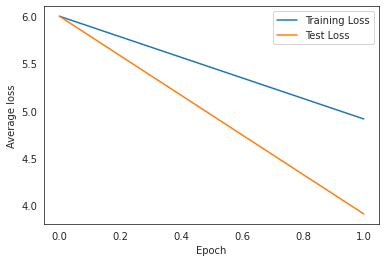

-------------------------------------------------------------------------------
Epoch starting at: 01:55:05
Epoch: 2, batch: 178/178, loss: 3.47591
Test Error:
Acc@1: 18.90%, Acc@5: 42.67%, Acc@10: 54.94%, Acc@20: 68.50% Avg loss: 3.874940
Epoch duration: 0:39



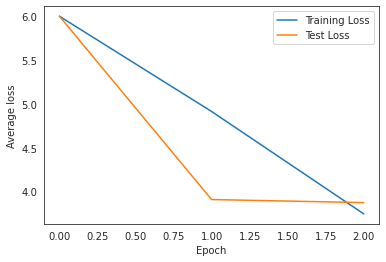

-------------------------------------------------------------------------------
Epoch starting at: 01:55:45
Epoch: 3, batch: 178/178, loss: 2.96640
Test Error:
Acc@1: 17.92%, Acc@5: 43.05%, Acc@10: 56.61%, Acc@20: 70.22% Avg loss: 3.945284
Epoch duration: 0:40



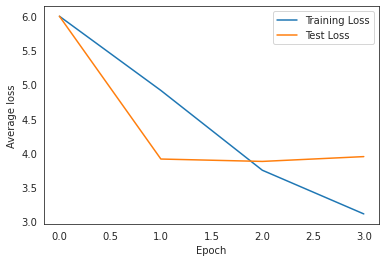

In [188]:
num_epochs = 3
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4][2:]
num_layers_values = [1, 5, 10]
conv_sizes = [24, 48, 64, 128][1:]

try:            
    for learning_rate in learning_rates:
        for conv_size in conv_sizes:

            cnn = CNN(num_classes=num_classes,
                      input_size=num_features,
                      conv_size=conv_size,
                      skills=skills, 
                      certs=certs,
                      licenses=licenses,
                      languages=languages,
                      addresses=addresses,
                      w2v=w2v,
                      address_embedding_size=25,
                      candidate_lengths=candidate_lens,
                      max_len=max_len)

            cnn = cnn.to(device)

            optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

            print(f"Current iteration {current}/{len(learning_rates) * len(num_layers_values) * len(conv_sizes)}")
            print(f"- Initial learning rate: {learning_rate}\n- Model: \n\n", cnn, "\n")

            # Store results of current configuration
            outcome = train_loop(cnn, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)
            outcome["lr"] = [learning_rate] * num_epochs
            outcome["Convolution size"] = [conv_size] * num_epochs

            full_results.append(outcome)

            current += 1
            
            break

        # We ignore LR for now
        break
except KeyboardInterrupt:
    pass

In [189]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "Convolution size", "Epoch"])

In [190]:
total

Acc@1     Acc@5    Acc@10    Acc@20  \
lr    Convolution size Epoch                                           
0.001 48               1      0.174940  0.443790  0.567685  0.690965   
                       2      0.189009  0.426731  0.549439  0.684986   
                       3      0.179160  0.430468  0.566146  0.702220   

                              test_loss  training_loss  
lr    Convolution size Epoch                            
0.001 48               1       3.909813       4.913895  
                       2       3.874940       3.745925  
                       3       3.945284       3.106443

Batch accuracy: 0.18359375

Previous-job baseline accuracy: 0.0
Majority class accuracy: 0.134765625

Fraction of previous job predictions: 0.017578125
Majority class predictions: 0.1171875


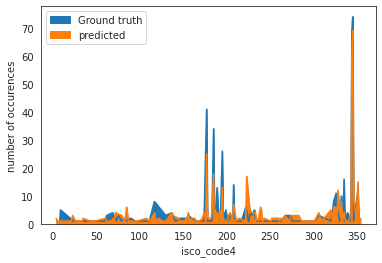

In [194]:
with torch.no_grad():
    for candidate, career, job in valloader:
        candidate, career, job = candidate.to(device), career.to(device), job.to(device)
        pred = cnn(career)
        
        print("Batch accuracy:", (pred.argmax(1) == job).type(torch.float).mean().item())    
        print()

        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area", label="Ground truth")
        
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area", label="predicted")
        plt.xlabel("isco_code4")
        plt.ylabel("number of occurences")
        plt.legend()
       
        
        # Check how often the model predicted the previous job + compare to baseline performance
        previous_job = torch.LongTensor(career_paths.loc[candidate.cpu()].apply(lambda x: x[-2][-1]).values).to(device)
        print("Previous-job baseline accuracy:", (job == previous_job).cpu().numpy().mean())
        print("Majority class accuracy:", (job == majority_class).cpu().numpy().mean())
        print()
        
        print("Fraction of previous job predictions:", (pred.argmax(1) == previous_job).cpu().numpy().mean())
        print("Majority class predictions:", (pred.argmax(1) == majority_class).cpu().numpy().mean())
        
        plt.show()        
        break

In [195]:
target_layer = cnn.conv1d

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=cnn, target_layer=target_layer, use_cuda=True)

In [196]:
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)

In [202]:
overall = []

for c, i, j in tqdm(trainloader):
    c, i, j = c.to(device), i.to(device), j.to(device)
    a = cam(input_tensor=i)
    overall.append(a.mean(axis=0).T)

<AxesSubplot:>

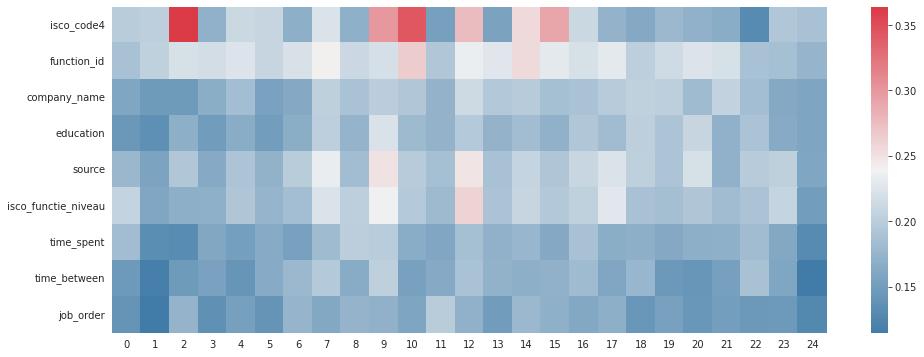

In [204]:
plt.figure(figsize=(16, 6))
sns.heatmap(np.array(overall).mean(axis=0)[:,::-1], cmap=cmap, yticklabels=features[::-1])